# 对Acfun网站关于“疫情”话题的视频数据分析
## 数据来源和数据说明  
* 使用“八爪鱼”软件爬取，由于A站规模较小，数据总共只有357个，项目包括以下：

    * **分区：**视频投稿分区 
    * **标题：**视频标题文本
    * **id：**投制视频up主
    * **发布时间：**视频发布时间
    * **播放：**视频播放量
    * **弹幕：**视频弹幕总量
    * **评论：**视频下方评论总量
    * **收藏：**视频被收藏次数
    * **香蕉：**A站的奖励机制，观看者可以对自己喜欢的视频进行“投蕉”，数目为1-5个
    * **关注：**up主粉丝数
    * **简介：**视频简介
    
## 目的
1. 视频播放量与关注，弹幕，评论，收藏，香蕉的关系；
2. 通过爬取的数据分析是否能通过标题文本判断所属分区；
3. 能否通过播放量，弹幕，评论，收藏，香蕉数据判断视频所属分区。

## 总结
1. 通过回归分析和关联性分析可以看出，视频播放量与弹幕，评论，收藏，香蕉存在明显的相关性，这些都是属于“热度”指数，都是反应视频热度的相关量；
2. 对于“标题”文本进行分类：
    * 由于A站规模较小，关于“疫情”话题总共只有357个视频数据，总共9个分区的情况下，部分分区的数据样本低于10个，在此将其舍去，对剩下的5个分区进行分类
    * 使用了正则表达式和jieba分词对中文进行了分词处理，利用TD-IDF对文本进行了数值化处理
    * 5个分区的数据量还是不平衡，为了解决数据不平衡的问题，在此使用了SMOTE上采样
    * 对采样后的数据，分别使用了朴素贝叶斯和随机森林两种方式建立模型，绘制learning-curve观察当前模型所处状态。对于伯努利贝叶斯，调参后，test文本分类准确率能达到93%；对于随机森林调参后，文本分类准确率能到86%。相比之下，朴素贝叶斯计算时间更短，在文本分类场景下，朴素贝叶斯具有一定优势
3. 使用播放量，弹幕，评论，收藏，香蕉数据判断视频分区
    * 因为播放量，弹幕，评论，收藏，香蕉数据都属于与视频热度相关的指数，因此使用了PCA降维到2维，便于可视化，此时协方差矩阵前两个特征值占比97%左右。
    * 对于降维后的特征heat_index1和heat_index2尝试进行聚类分析，发现无论是使用距离划分KMeans还是密度DBSCAN分类效果都很差
    * 重新对未降维的5个特征播放量，弹幕，评论，收藏，香蕉，进行了LDA降维处理。计算不同分区分组后的各个热度指数平均值发现，不同分组的均值差异明显，因此使用监督性降维LDA可以使得样本数据靠近组内均值。降维后发现效果也不好，对不同分组各个热度指数画柱状图分析，发现虽然不同分组热度指数均值差别较大，但是不同分组热度指数处于相同水平的数据较多，也就是数据交叠较多，因此对于这些数据也取得不了好的效果。
    * 总的来说，使用播放量，弹幕，评论，收藏，香蕉数据判断视频分区，在此样本数据下效果并不理想，总的数据样本太少，导致数据两极分化严重，不同分区下，热度指数处于相同水平的数据交叠多，难以进行分类。

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

acfun = pd.read_csv('acfun_yiqing.csv')
print(acfun.shape)

(357, 11)


## 数据如下: 总共11个项目，357个样本

In [2]:
acfun.head()

,分区,标题,id,发布时间,播放,弹幕,评论,收藏,香蕉,关注,简介
0,鱼塘,骁话一下：面对疫情日本为什么不取消奥运？带你算算政治经济社会三本账,观察者网,发布于 2020-2-29,33680,351,146,339,3477,关注 32273,对疫情装聋作哑，对奥运全力出击。日本花了7年斥巨资筹备奥运会，经历了各种丑闻与风波，总算熬到...
1,生活,德国小伙发起的“我是中国”还在继续，面对疫情德国人真的准备好了？,Hey_Tobi,发布于 2020-2-28,33434,63,85,216,2635,关注 5113,三周前，德国小伙Tobi为反对排外反对歧视发起的”I am China”还在继续，来看看德国...
2,科技,【懂点儿啥32】韩国最大的“疫情”，就是他们的邪教,观察者网,发布于 2020-2-29,45950,951,187,444,3814,关注 32273,哈利路亚~韩国邪教五花八门，他们对信徒实行精神控制，强奸、贩卖女性，却能打着“和平”等名义四...
3,生活,疫情期间我囤了2周的物资和大蒜！德国人还不当回事？,Hey_Tobi,发布于 2020-3-2,13420,147,129,80,1613,关注 5113,新型冠状病毒蔓延到了德国，离我很近的地方出现了病例。根据中国的经验，我买了2周的物资。还不把...
4,鱼塘,【北美报哥】在美国面对疫情该不该去抢购,北美报哥,发布于 2020-3-2,29768,255,228,217,3399,关注 12.6万,在目前状况下，你们真的需要去抢购么？


## 通过jieba分词和词云查看各分区数量占比
可以看到，**生活，科技，鱼塘**三个分区占比最大，最少的分区**体育**仅有4个样本。考虑使用采样办法解决数据样本不均衡问题。

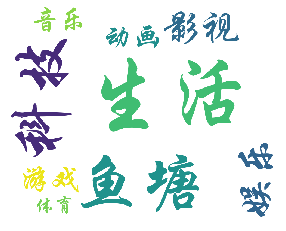

,分区,标题
0,体育,4
1,动画,10
2,娱乐,22
3,影视,18
4,游戏,11
5,生活,146
6,科技,65
7,音乐,9
8,鱼塘,72


In [3]:
import jieba 
from wordcloud import WordCloud
from PIL import Image
font = r'C:\Windows\Fonts\STXINGKA.TTF'
string = acfun.分区.values
string = ' '.join(string)
wc = WordCloud(background_color='white',width=1000,height=800,font_path=font)
wc.generate_from_text(string)
plt.imshow(wc)
plt.axis('off')
plt.show()
acfun[['标题','分区']].groupby(['分区'],as_index=False).count()

## 一、数据预处理:主要包括数据格式转化，关联性分析，特征提取。
### 1.1 数据格式转化
1. 时间项标准化处理；
2. 将**播放，评论，弹幕**项目中的数据转化为数字，如“12.6万”转换为“126000”，“1,400”转化为“1400”；
3. 对于**标题**项中文文本处理，使用结巴分词和TD-IDF转换；  
4. 将$target$**分区**进行Label化，模型训练时转化成ordinal values；

In [4]:
def guanzhu(s):
    s = s.split()[-1]
    if '万' in s:
        s = float(s.split('万')[0])*10000
    return int(s)

def time_process(t):
    t = t.split()[-1]
    if ('小时' in t) or ('分钟' in t):
        t = pd.to_datetime('20200303')
    else:
        t = pd.to_datetime(t)
    return t

def int_1(s):
    if '万' in str(s):
        s = float(s.split('万')[0])*10000
    elif ',' in str(s):
        s = s.split(',')[0]+s.split(',')[1]
    return int(s)

acfun.关注=acfun.关注.apply(guanzhu)
acfun.发布时间 = acfun.发布时间.apply(time_process)
acfun.评论 = acfun.评论.apply(int_1)
acfun.弹幕 = acfun.弹幕.apply(int_1)
acfun.播放 = acfun.播放.apply(int_1)
from bs4 import BeautifulSoup
import re
import jieba
def extract(title):
    text = BeautifulSoup(title).get_text()
    text = re.sub(u"([^\u4e00-\u9fa5])",'',text)
    return text

def cut_words(title):
    text = list(jieba.cut(title))
    
    text = ' '.join(text)
    return text
acfun.标题 = acfun.标题.apply(extract)
acfun.标题 = acfun.标题.apply(cut_words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\MYChen\AppData\Local\Temp\jieba.cache
Loading model cost 0.651 seconds.
Prefix dict has been built successfully.


In [5]:
acfun.head()

,分区,标题,id,发布时间,播放,弹幕,评论,收藏,香蕉,关注,简介
0,鱼塘,骁话 一下 面对 疫情 日本 为什么 不 取消 奥运 带 你 算算 政治 经济社会 三本 账,观察者网,2020-02-29,33680,351,146,339,3477,32273,对疫情装聋作哑，对奥运全力出击。日本花了7年斥巨资筹备奥运会，经历了各种丑闻与风波，总算熬到...
1,生活,德国 小伙 发起 的 我 是 中国 还 在 继续 面对 疫情 德国人 真的 准备 好 了,Hey_Tobi,2020-02-28,33434,63,85,216,2635,5113,三周前，德国小伙Tobi为反对排外反对歧视发起的”I am China”还在继续，来看看德国...
2,科技,懂 点儿 啥 韩国 最大 的 疫情 就是 他们 的 邪教,观察者网,2020-02-29,45950,951,187,444,3814,32273,哈利路亚~韩国邪教五花八门，他们对信徒实行精神控制，强奸、贩卖女性，却能打着“和平”等名义四...
3,生活,疫情 期间 我 囤 了 周 的 物资 和 大蒜 德国人 还 不 当回事,Hey_Tobi,2020-03-02,13420,147,129,80,1613,5113,新型冠状病毒蔓延到了德国，离我很近的地方出现了病例。根据中国的经验，我买了2周的物资。还不把...
4,鱼塘,北美 报哥 在 美国 面对 疫情 该不该 去 抢购,北美报哥,2020-03-02,29768,255,228,217,3399,126000,在目前状况下，你们真的需要去抢购么？


In [6]:
acfun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 11 columns):
分区      357 non-null object
标题      357 non-null object
id      357 non-null object
发布时间    357 non-null datetime64[ns]
播放      357 non-null int64
弹幕      357 non-null int64
评论      357 non-null int64
收藏      357 non-null int64
香蕉      357 non-null int64
关注      357 non-null int64
简介      251 non-null object
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 30.8+ KB


### 1.2 关联性分析和特征提取

#### 做出假设：播放，弹幕，评论，收藏，香蕉都属于与视频热度有关的数据，因此存在相关关系。关注(fans)数目也一定程度上可能左右视频热度。下面尝试做回归分析。 

使用简单的线型回归结果如下，可以看到用**弹幕，评论，收藏，香蕉**去拟合**播放**项拟合相当好，$R^2=0.983$。使用train_test_split进行数据集拆分，对测试样本计算$R^2=0.95$，回归效果不错。但是注意，由于总的样本量较少，test score对于随机抽取的样本敏感。

In [7]:
X = acfun.loc[:][['弹幕','评论','收藏','香蕉']]
y = acfun.loc[:][['播放']] 
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)
print('相关系数：',model.coef_)
print('R^2=',model.score(X,y))

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=1)
model = LinearRegression()
model.fit(X_train,y_train)
print('test样本R^2=',model.score(X_test,y_test))

相关系数： [[-8.2819379  31.81204736 40.56910858  5.57021848]]
R^2= 0.9833782411552608
test样本R^2= 0.9499636827020839


通过求协方差矩阵，可以看出，**播放，弹幕，评论，收藏，香蕉**相关性较大，考虑做降维处理，提取新的特征。

             bofang     danmu   comment  shoucang    banana  attention
bofang     1.000000  0.886504  0.951581  0.800159  0.985174   0.911785
danmu      0.886504  1.000000  0.934574  0.852719  0.868231   0.782630
comment    0.951581  0.934574  1.000000  0.834473  0.937744   0.881884
shoucang   0.800159  0.852719  0.834473  1.000000  0.736487   0.688838
banana     0.985174  0.868231  0.937744  0.736487  1.000000   0.915107
attention  0.911785  0.782630  0.881884  0.688838  0.915107   1.000000


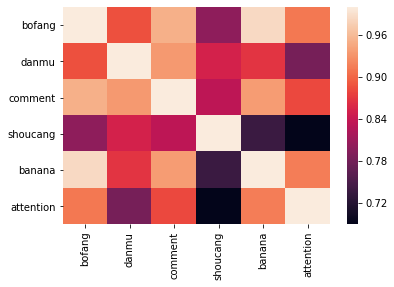

In [8]:
'''可以看出关联性很大，可以进行降维处理'''
acfun=acfun.rename(columns={'标题':'title','发布时间':'time','关注':'attention','简介':'abstract','分区':'target','播放':'bofang',
                            '弹幕':'danmu','评论':'comment','收藏':'shoucang','香蕉':'banana'})
print(acfun.corr())
import seaborn as sns
sns.heatmap(acfun.corr(),)

可以看到，将播放，弹幕，评论，收藏，香蕉降维到2维，协方差矩阵特征值占比接近$97\%$。因此，将这5维数据降维到2维提取出新的特征heat_index1和heat_index2

In [9]:
from sklearn.decomposition import PCA
df = acfun.loc[:][['bofang','danmu','comment','shoucang','banana',]]
from sklearn import preprocessing
### 标准化数据
df = df.apply(preprocessing.scale)
df.head()
pca = PCA(n_components=2)
data = df.values
pca.fit(data)
print(pca.explained_variance_ratio_) 
data_new = pca.transform(data)

[0.90411359 0.06297538]


In [10]:
df_new = pd.DataFrame(data_new,columns = ['heat_index1','heat_index2'])
df_new.head()
acfun_new = pd.concat([acfun,df_new],axis=1)

In [11]:
acfun_new.head()
acfun_drop = acfun_new.drop(['bofang','danmu','comment','shoucang','banana',],axis=1)
acfun_new.head()

,target,title,id,time,bofang,danmu,comment,shoucang,banana,attention,abstract,heat_index1,heat_index2
0,鱼塘,骁话 一下 面对 疫情 日本 为什么 不 取消 奥运 带 你 算算 政治 经济社会 三本 账,观察者网,2020-02-29,33680,351,146,339,3477,32273,对疫情装聋作哑，对奥运全力出击。日本花了7年斥巨资筹备奥运会，经历了各种丑闻与风波，总算熬到...,6.873407,3.359216
1,生活,德国 小伙 发起 的 我 是 中国 还 在 继续 面对 疫情 德国人 真的 准备 好 了,Hey_Tobi,2020-02-28,33434,63,85,216,2635,5113,三周前，德国小伙Tobi为反对排外反对歧视发起的”I am China”还在继续，来看看德国...,3.942053,1.488246
2,科技,懂 点儿 啥 韩国 最大 的 疫情 就是 他们 的 邪教,观察者网,2020-02-29,45950,951,187,444,3814,32273,哈利路亚~韩国邪教五花八门，他们对信徒实行精神控制，强奸、贩卖女性，却能打着“和平”等名义四...,11.068331,5.407763
3,生活,疫情 期间 我 囤 了 周 的 物资 和 大蒜 德国人 还 不 当回事,Hey_Tobi,2020-03-02,13420,147,129,80,1613,5113,新型冠状病毒蔓延到了德国，离我很近的地方出现了病例。根据中国的经验，我买了2周的物资。还不把...,2.895278,0.328746
4,鱼塘,北美 报哥 在 美国 面对 疫情 该不该 去 抢购,北美报哥,2020-03-02,29768,255,228,217,3399,126000,在目前状况下，你们真的需要去抢购么？,6.265714,1.434997


In [12]:
acfun_drop.head()

,target,title,id,time,attention,abstract,heat_index1,heat_index2
0,鱼塘,骁话 一下 面对 疫情 日本 为什么 不 取消 奥运 带 你 算算 政治 经济社会 三本 账,观察者网,2020-02-29,32273,对疫情装聋作哑，对奥运全力出击。日本花了7年斥巨资筹备奥运会，经历了各种丑闻与风波，总算熬到...,6.873407,3.359216
1,生活,德国 小伙 发起 的 我 是 中国 还 在 继续 面对 疫情 德国人 真的 准备 好 了,Hey_Tobi,2020-02-28,5113,三周前，德国小伙Tobi为反对排外反对歧视发起的”I am China”还在继续，来看看德国...,3.942053,1.488246
2,科技,懂 点儿 啥 韩国 最大 的 疫情 就是 他们 的 邪教,观察者网,2020-02-29,32273,哈利路亚~韩国邪教五花八门，他们对信徒实行精神控制，强奸、贩卖女性，却能打着“和平”等名义四...,11.068331,5.407763
3,生活,疫情 期间 我 囤 了 周 的 物资 和 大蒜 德国人 还 不 当回事,Hey_Tobi,2020-03-02,5113,新型冠状病毒蔓延到了德国，离我很近的地方出现了病例。根据中国的经验，我买了2周的物资。还不把...,2.895278,0.328746
4,鱼塘,北美 报哥 在 美国 面对 疫情 该不该 去 抢购,北美报哥,2020-03-02,126000,在目前状况下，你们真的需要去抢购么？,6.265714,1.434997


## 二、 分析标题文本与分区之间的关系
观察数据项，需要对数据进行如下处理：
* 转化  
    1. 因为**标题**项目中的符号不影响中文的意义表达，所以考虑舍去符号，从中提取汉字，再利用jieba分词进行分词处理，此前已完成。后面利用TDIDF进行特征转化；
    2. 将$target$**分区**进行Label化，转化成ordinal values；


### 2.1 数据不平衡进行采样操作 
对于**体育，音乐，动画，游戏**四个类别进行舍弃，因为数目过少，数据很难具有代表性。将**title**中的文档进行TD-IDF处理，Label化**target**

In [13]:
acfun_for_train = acfun_drop[~acfun_drop['target'].isin(['体育','音乐','游戏','动画'])]
#### 特征处理 TF-IDF = TF*idf 
acfun_for_train.head()
print(acfun_for_train.shape)
print(acfun_for_train.target.unique())

(323, 8)
['鱼塘' '生活' '科技' '影视' '娱乐']


In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer as TFIV
from sklearn.preprocessing import LabelEncoder
from collections import Counter
document = []
for i in range(len(acfun_for_train)):
    document.append(acfun_for_train.title.values[i])
print(len(document))
tfv = TFIV()
tfv.fit(document)
sparse_result = tfv.transform(document)
print(sparse_result.shape)
X = sparse_result
y = LabelEncoder().fit_transform(acfun_for_train.target)

from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=1,)
X_smo,y_smo = smo.fit_sample(X,y)
print(Counter(y_smo))

323
(323, 1355)
Counter({4: 146, 2: 146, 3: 146, 1: 146, 0: 146})


### 2.2 模型建立

0.9246575342465754
0.8698630136986302


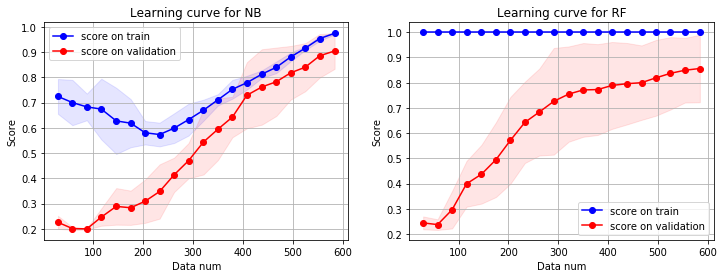

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import BernoulliNB as MNB
from matplotlib.gridspec import GridSpec

X_train,X_test,y_train,y_test = train_test_split(X_smo,y_smo,test_size=0.2,random_state=0)
model_NB = MNB(alpha=1., class_prior=None, fit_prior=False)
model_NB.fit(X_train,y_train)
print(model_NB.score(X_test,y_test))

from sklearn.ensemble import RandomForestClassifier
rf0 = RandomForestClassifier(random_state=1)
rf0.fit(X_train,y_train)
print(rf0.score(X_test,y_test))

def plot_learning_curve(estimator, ax,title, X, y, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20),):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#     plt.figure()
    ax.set_title(title)
    ax.set_xlabel('Data num')
    ax.set_ylabel('Score')
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                     alpha=0.1, color='b')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                     alpha=0.1, color='r')
    ax.plot(train_sizes, train_scores_mean, 'o-', color='b', label='score on train')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='r', label='score on validation')
    ax.legend(loc='best')
#     plt.show()
plt.figure(figsize=(12,4))
G = GridSpec(1,2)
ax = plt.subplot(G[0,0])
plot_learning_curve(model_NB, ax,"Learning curve for NB", X_smo,y_smo,)
ax2 = plt.subplot(G[0,1])
plot_learning_curve(rf0, ax2,"Learning curve for RF", X_smo,y_smo,)

从learning-curve来看，随机森林属于过拟合状态，需要更多的训练集，或者后续调参增加泛化能力。

### 2.3 下面分别针对朴素贝叶斯和随机森林进行调参
1. 对朴素贝叶斯alpha值进行调参，取0.25。调参之后相比之前准确率有所提高

In [16]:
from sklearn.model_selection import GridSearchCV
### 朴素贝叶斯调参
param_NB = {'alpha':np.arange(0.1,2,0.05)}
gsearch_NB = GridSearchCV(estimator=MNB(alpha=1., class_prior=None, fit_prior=False),
                         param_grid=param_NB,cv=5,scoring='accuracy')
gsearch_NB.fit(X_train,y_train)
print(gsearch_NB.best_params_,gsearch_NB.best_score_)

model_NB = MNB(alpha=0.25, class_prior=None, fit_prior=False)
model_NB.fit(X_train,y_train)
print(model_NB.score(X_test,y_test))
print(model_NB.predict)

{'alpha': 0.25000000000000006} 0.9332301797819038
0.9315068493150684
<bound method _BaseNB.predict of BernoulliNB(alpha=0.25, binarize=0.0, class_prior=None, fit_prior=False)>


2. 对随机森林进行调参  
    max_depth=17, n_estimators=50,对于min_samples_split和min_samples_leaf，由于样本数量很小，所以不进行调参。调参之后发现改变n_estimators为50，准确率略高，但是max_depth改成17，准确率会变低。可能与样本质量有关，因为大量样本是采用重采样取得的，这样实际上样本的相似度很大，max_depth越深对test样本正确率也会越高。

In [127]:
param_rf = {'n_estimators':np.arange(10,101,20)}
gsearch_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=1,oob_score=True),
                         param_grid=param_rf,cv=5,)
gsearch_rf.fit(X_train,y_train)
gsearch_rf.best_params_,gsearch_rf.best_score_

({'n_estimators': 50}, 0.8133068081343943)

In [128]:
param_rf = {'max_depth':range(5,20,2)}
gsearch_rf = GridSearchCV(estimator=RandomForestClassifier(n_estimators=50,random_state=1,oob_score=True),
                         param_grid=param_rf,cv=5,)
gsearch_rf.fit(X_train,y_train)
gsearch_rf.best_params_,gsearch_rf.best_score_

({'max_depth': 17}, 0.7602269378131447)

In [135]:
rf1 = RandomForestClassifier(n_estimators=50,random_state=1,oob_score=True)
rf1.fit(X_train,y_train)
print(rf1.score(X_test,y_test))

0.8767123287671232


## 小结：
1. 所爬取的数据各个target分区数据量差别十分明显，数据不平衡。样本少的**“体育”**只有四个，样本多的**“生活”**有146个，所以决定舍去最少的4个target分区数据进行分类处理实验；
2. 对**标题**文本进行了分词和TD-IDF处理；
2. 舍去样本量很小的分区后，利用SMOTE进行了重采样；
3. 对于重采样之后的数据，利用朴素贝叶斯和随机森林进行分类处理，对于test数据分类准确率都比较高，贝叶斯为92%左右，随机森林87%，而且朴素贝叶斯耗时更短。对于文本分类，朴素贝叶斯确实表现很好；
4. 以上说明，仅仅通过**标题**文本内容有比较高的正确率判断**视频投递分区**。

## 三、 下面尝试采用heat_index，降维前热度相关数据，关注量进行分区 

### 3.1 heat_index分区
1. 对SMOTE采样前后的数据分别以heat_index1和heat_index2降维提取后的特征为横纵坐标画散点图。可以看到，不管从距离度量还是密度度量上看，都没有明显的分类趋势，预计不论是使用距离度量的KMeans,Meanshift还是使用密度度量的DBSCAN,OPTICS，聚类分析效都不会好。
2. 对SMOTE采样后的数据尝试了KMeans和DBSCAN聚类，结果如预期，效果很差。

In [20]:
acfun_for_train.head()

X = acfun_for_train.loc[:][['heat_index1','heat_index2']].values
y = LabelEncoder().fit_transform(acfun_for_train.target)

from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=1,)
X_smo,y_smo = smo.fit_sample(X,y)
print(X_smo.shape,Counter(y_smo))

(730, 2) Counter({4: 146, 2: 146, 3: 146, 1: 146, 0: 146})


Text(0, 0.5, 'heat_index2')

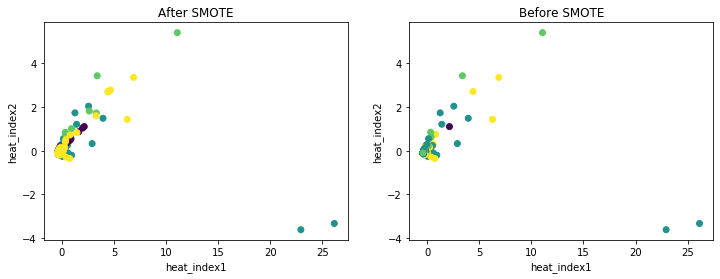

In [27]:
from matplotlib.gridspec import GridSpec

G = GridSpec(1,2)
fig = plt.figure(figsize=(12,4))
ax = plt.subplot(G[0,0])
ax.scatter(X_smo[:,0],X_smo[:,1],c=y_smo)
ax.set_title('After SMOTE')
ax.set_xlabel('heat_index1')
ax.set_ylabel('heat_index2')
ax2 = plt.subplot(G[0,1])
ax2.scatter(acfun_for_train.heat_index1,acfun_for_train.heat_index2,c=y)
ax2.set_title('Before SMOTE')
ax2.set_xlabel('heat_index1')
ax2.set_ylabel('heat_index2')

**尝试使用KMeans，DBSCAN分类**

{0, 1, 2, 3, 4}
{0, 1, -1}


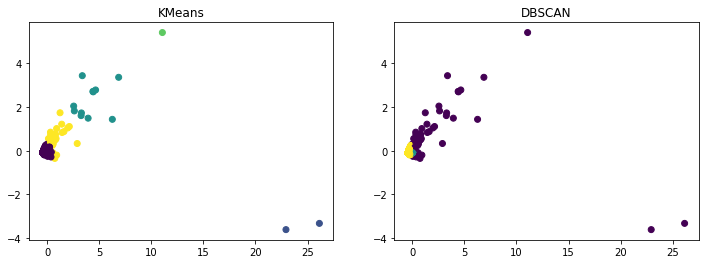

In [100]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
### KMeans
model = KMeans(n_clusters=5,random_state=1)
model.fit(X_smo)
fig=plt.figure(figsize=(12,4))
G=GridSpec(1,2)
ax = plt.subplot(G[0,0])
ax.scatter(X_smo[:,0],X_smo[:,1],c=model.labels_)
ax.set_title('KMeans')
print(set(model.labels_))
### OPTICS
dbs = DBSCAN(eps=0.1,min_samples=5,algorithm='auto')
dbs.fit(X_smo)
ax = plt.subplot(G[0,1])
ax.scatter(X_smo[:,0],X_smo[:,1],c=dbs.labels_)
ax.set_title('DBSCAN')
print(set(dbs.labels_))

### 3.2 LDA降维尝试
以上使用的是PCA降维提取的特征进行聚类分析，现在我们知道各个样本的label，可以尝试使用LDA降维。PCA降维是基于方差的，对于不同target分区，与热度相关的指标（播放，弹幕，香蕉等）应该均值不同，这种情况下尝试使用使用LDA降维。  

(323, 5) (323,)


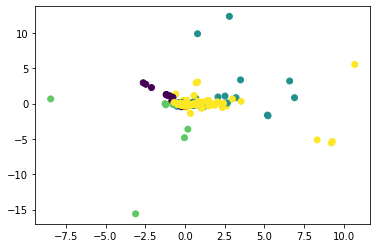

In [53]:
acfun_drop_lda = acfun[~acfun['target'].isin(['体育','音乐','游戏','动画'])]
df_lda = acfun_drop_lda.loc[:][['bofang','danmu','comment','shoucang','banana']]

X_lda = df_lda.values
y_lda = LabelEncoder().fit_transform(acfun_drop_lda.target)
print(X_lda.shape,y_lda.shape)

smo = SMOTE(random_state=1,)
X_smo_lda,y_smo_lda = smo.fit_sample(X_lda,y_lda)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_smo_lda,y_smo_lda)
X_lda_new = lda.transform(X_smo_lda)
plt.scatter(X_lda_new[:, 0], X_lda_new[:, 1],marker='o',c=y_smo_lda)

可以看到上面使用LDA降维效果不理想，分析原因如下：  
* 简单计算不同分区下热度相关指数均值如下表，可以看出，均值方面存在比较明显的区别。LDA效果不理想原因之一可能是，各个分区虽然“热度”均值有所差别，但是“热度”数据处于同一水平的较多，也就是数据交叠比较多。 
* 对娱乐和鱼塘两个分区的各个热度指数画图分析，可以看出：1.对所有的热度指数两级分化明显；2.两个不同分区，数据较小的都比较多，数据交叠严重，因此LDA降维效果不理想。当然这与总的样本量较少也有关系。

In [55]:
acfun_drop_lda.head()
acfun_drop_lda[['target','bofang','danmu','comment','shoucang','banana']].groupby('target',as_index=False).mean()

,target,bofang,danmu,comment,shoucang,banana
0,娱乐,1027.272727,1.363636,2.318182,9.909091,101.272727
1,影视,482.944444,0.888889,0.444444,3.777778,19.944444
2,生活,3675.876712,18.541096,11.445205,14.068493,440.445205
3,科技,1416.692308,17.138462,4.261538,15.030769,93.553846
4,鱼塘,2747.555556,15.430556,10.680556,17.569444,173.138889


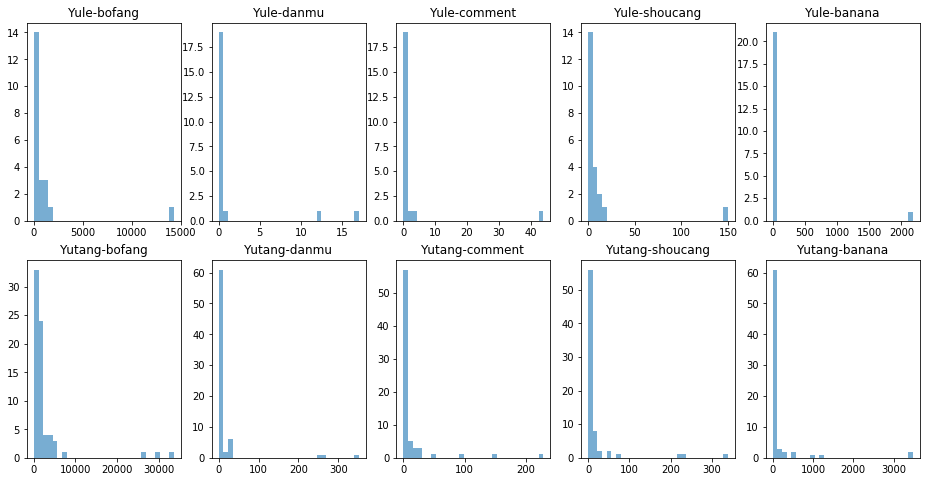

In [101]:
df_ent = acfun_drop_lda.loc[acfun_drop_lda.target=='娱乐']
df_yutang = acfun_drop_lda.loc[acfun_drop_lda.target=='鱼塘']
# df_yutang.head()
# plt.hist(df_yutang.danmu,bins=20)
df_list = [df_ent,df_yutang]
titles = ['Yule','Yutang']
fig = plt.figure(figsize=(16,8))
G = GridSpec(2,5)
lists = ['bofang','danmu','comment','shoucang','banana']
for i in range(2):
    for j in range(5):
        ax = plt.subplot(G[i,j])
        ax.hist(df_list[i][lists[j]],bins=30,alpha=0.6)
        title = titles[i]+'-'+lists[j]
        ax.set_title(title)

## 小结：
1. 为了方便可视化，将播放，弹幕，评论，收藏，香蕉5个特征降维到2维，协方差矩阵前两个特征值占比97%。
2. 利用降维后的heat_index1和heat_index2数据，尝试聚类分析进行视频分区分类，不论是基于距离划分KMeans还是密度划分的DBSCAN分类效果都不好。从原本的数据中也可以看出，对于不同分区的样本点，无论是距离上还是密度上都没有很好地划分。
3. 回到原本的播放，弹幕，评论，收藏，香蕉5个特征，猜测不同分区的这些热度指数均值会有差异，对此，先简单的分组求热度指数均值，发现确实存在明显差异。
4. 对于均值有明显差异的样本，采取LDA降维尝试。降维后的效果还是不太好，对原始5个特征数据针对“鱼塘”和“娱乐”两个分区画图分析，发现两个不同分区虽然热度均值有明显差异，但是两个分区都存在大量热度指数较小的样本，也就是对于这部分重叠较多，因此LDA降维效果不理想。